In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from ingestion_db import engine
from scipy.stats import ttest_ind
import scipy.stats as stats
warnings.filterwarnings('ignore')


In [3]:
df=pd.read_sql_query("SELECT * FROM vendor_sales_summary", engine)

# Exploratory Data Analysis
- Previously, we examined the various tables in the database to identify key variables, understand their relationships, and determine which ones should be included in the final analysis.

- In this phase of EDA, we will analyze the resultant table to gain insights into the distribution of each column. This will help us understand data patterns, identify anomalies, and ensure data quality before proceeding with further analysis.

In [4]:
#summary stats 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorNumber,10692.0,1.065065e+04,18753.519148,2.00,3951.000000,7153.000000,9552.000000,2.013590e+05
Brand,10692.0,1.803923e+04,12662.187074,58.00,5793.500000,18761.500000,25514.250000,9.063100e+04
PurchasePrice,10692.0,2.438530e+01,109.269375,0.36,6.840000,10.455000,19.482500,5.681810e+03
ActualPrice,10692.0,3.564367e+01,148.246016,0.49,10.990000,15.990000,28.990000,7.499990e+03
Volume,10692.0,8.473605e+02,664.309212,50.00,750.000000,750.000000,750.000000,2.000000e+04
TotalPurchaseQuantity,10692.0,3.140887e+03,11095.086769,1.00,36.000000,262.000000,1975.750000,3.376600e+05
TotalPurchaseDollars,10692.0,3.010669e+04,123067.799627,0.71,453.457500,3655.465000,20738.245000,3.811252e+06
TotalSalesQuantity,10692.0,3.077482e+03,10952.851391,0.00,33.000000,261.000000,1929.250000,3.349390e+05
TotalSalesDollars,10692.0,4.223907e+04,167655.265984,0.00,729.220000,5298.045000,28396.915000,5.101920e+06
TotalSalesPrice,10692.0,1.879378e+04,44952.773386,0.00,289.710000,2857.800000,16059.562500,6.728193e+05


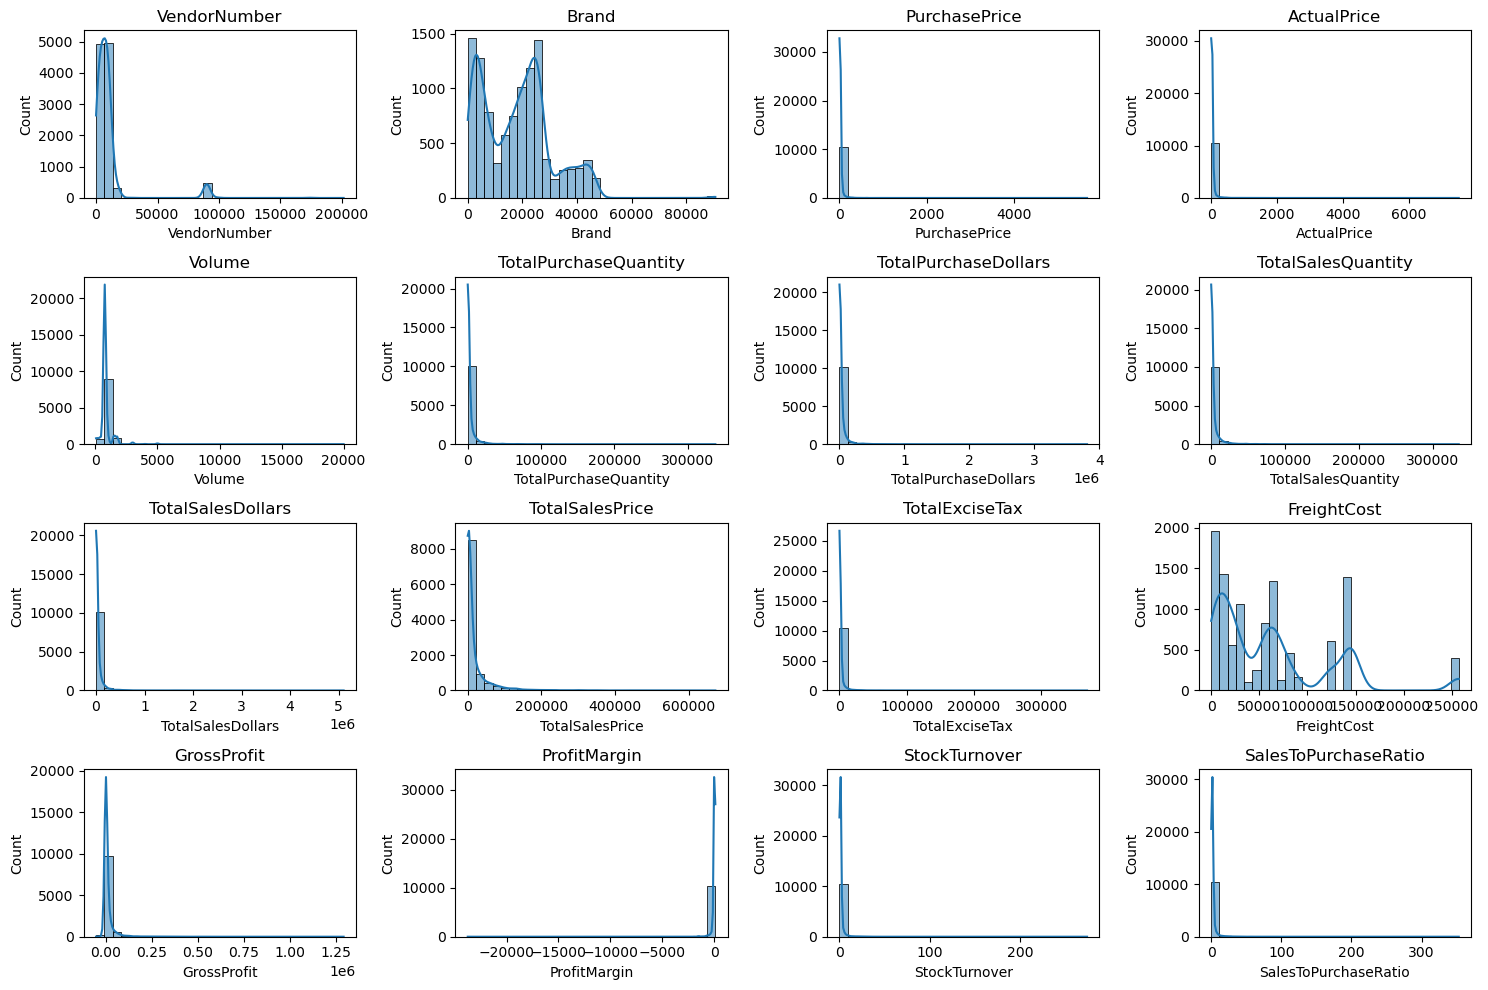

In [24]:
#distribution plots for numeric columns 
plt.figure(figsize=(15, 10))
numerical_cols=df.select_dtypes(include=np.number).columns
for i, col in enumerate(numerical_cols): 
    plt.subplot(4,4,i+1)
    sns.histplot(df[col],kde=True,bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

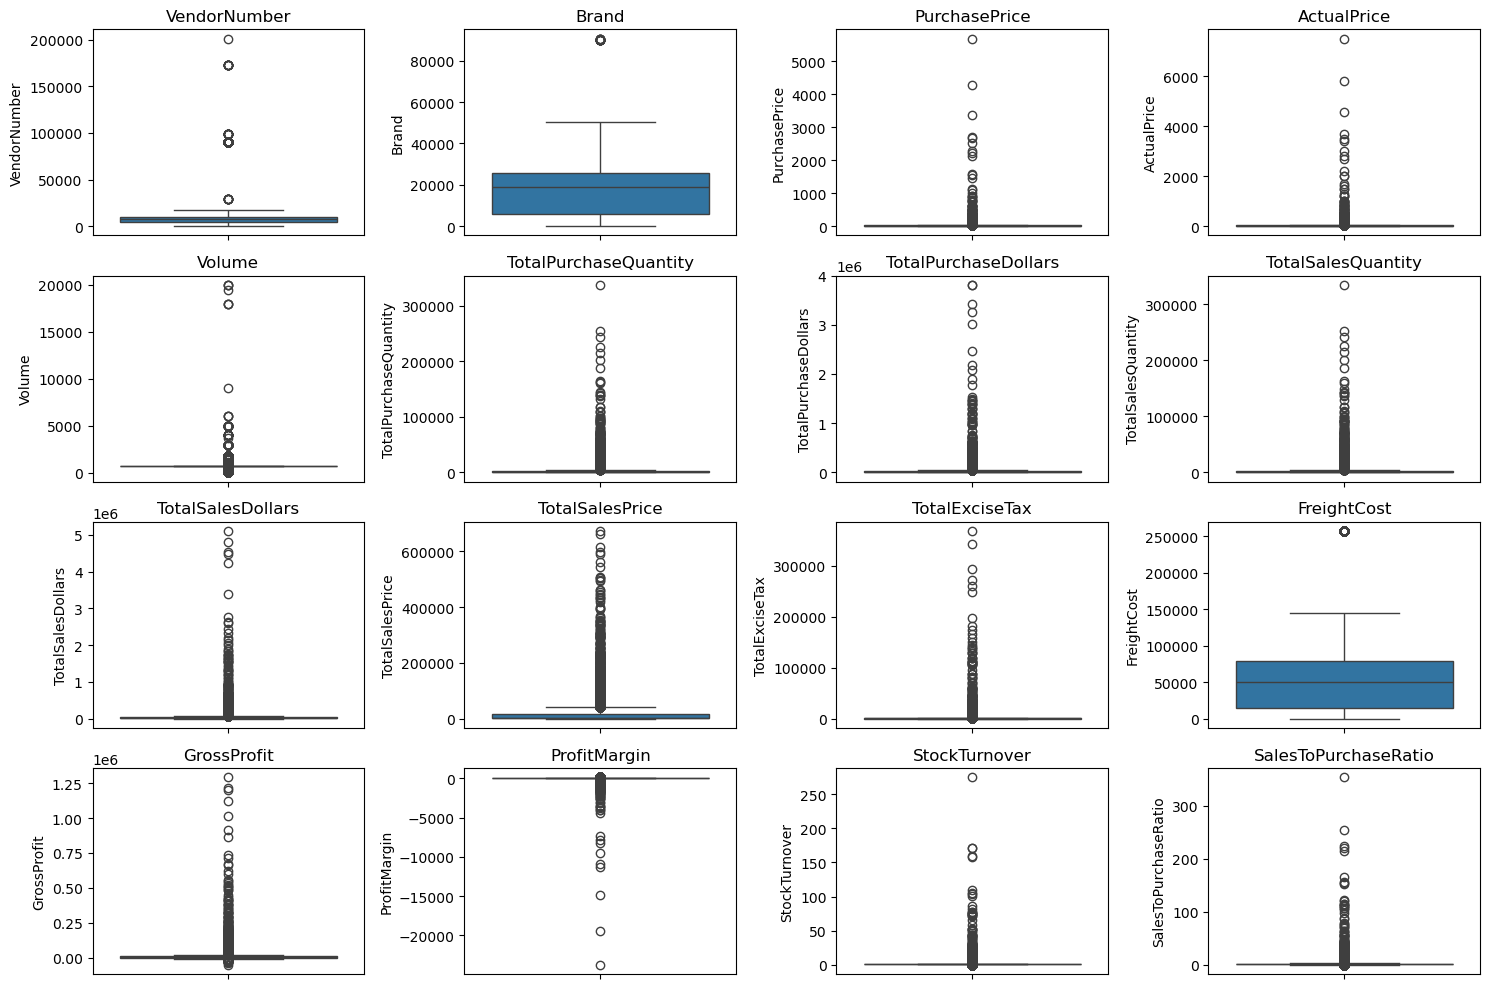

In [25]:
plt.figure(figsize=(15, 10))
numerical_cols=df.select_dtypes(include=np.number).columns
for i, col in enumerate(numerical_cols): 
    plt.subplot(4,4,i+1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# Summary Statistics Insights:
### Negative & Zero Values:
Gross Profit: Minimum value is -52,002.78, indicating losses. Some products or transactions may be selling at a loss due to high costs or selling at discounts lower than the purchase price.

Profit Margin: Has a minimum of -∞, which suggests cases where revenue is zero or even lower than costs.

Total Sales Quantity & Sales Dollars: Minimum values are 0, meaning some products were purchased but never sold. These could be slow-moving or obsolete stock.

### Outliers Indicated by High Standard Deviations:
Purchase & Actual Prices: The max values (5,681.81 & 7,499.99) are significantly higher than the mean (24.39 & 35.64), indicating potential premium products.

Freight Cost: Huge variation, from 0.09 to 257,032.07, suggests logistics inefficiencies or bulk shipments.

Stock Turnover: Ranges from 0 to 274.5, implying some products sell extremely fast while others remain in stock indefinitely. Value more than 1 indicates that Sold quantity for that product is higher than purchased quantity due to either sales are being fulfilled from older stock.

In [31]:
df=pd.read_sql_query("""select * from vendor_sales_summary where "GrossProfit" >0 and "ProfitMargin">0 and "TotalSalesQuantity" > 0""",engine)

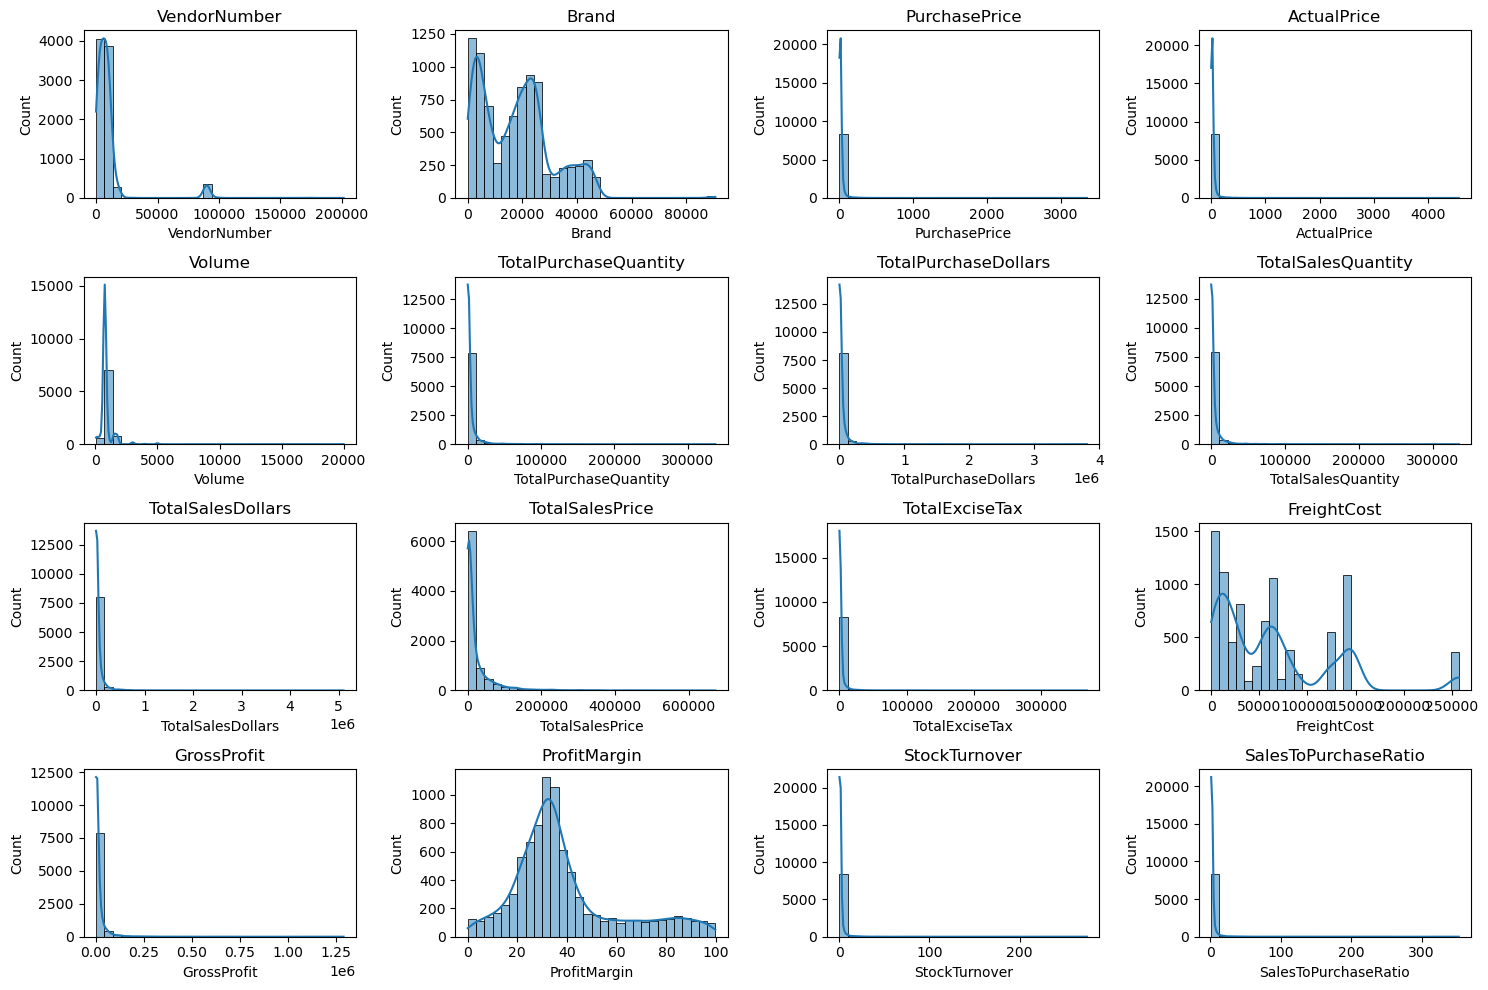

In [32]:
plt.figure(figsize=(15, 10))
numerical_cols=df.select_dtypes(include=np.number).columns
for i, col in enumerate(numerical_cols): 
    plt.subplot(4,4,i+1)
    sns.histplot(df[col],kde=True,bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

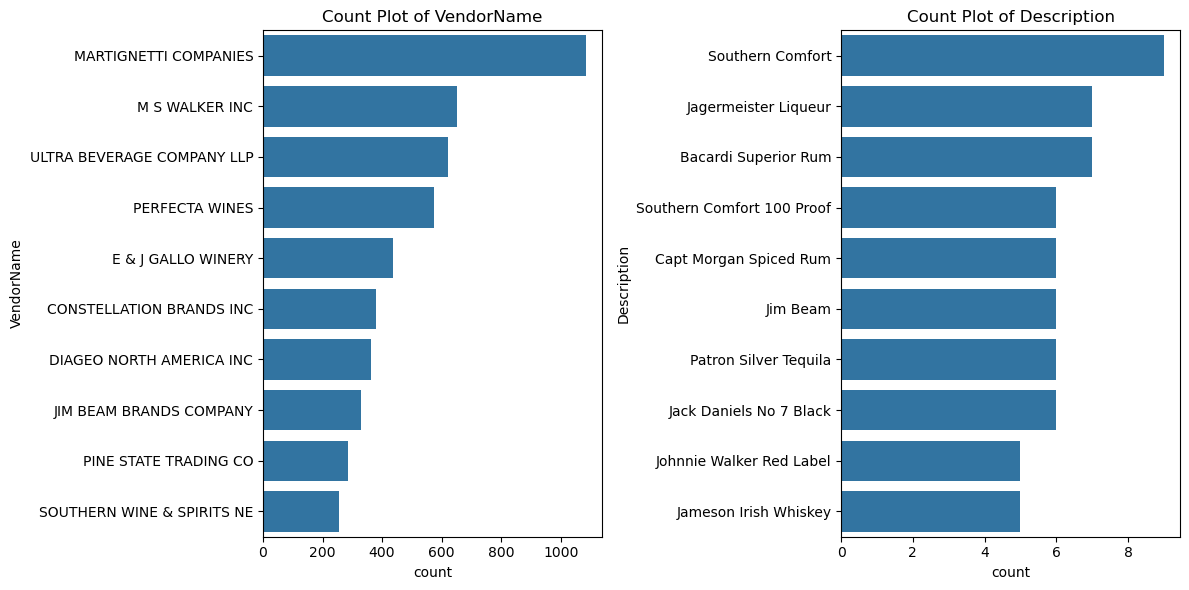

In [39]:
categorical_cols = ['VendorName', 'Description']

plt.figure(figsize=(12, 6))

for i, col in enumerate(categorical_cols):
    plt.subplot(1, 2, i + 1)
    sns.countplot(y=df[col], order=df[col].value_counts().index[:10])
    plt.title(f'Count Plot of {col}')

plt.tight_layout()
plt.show()


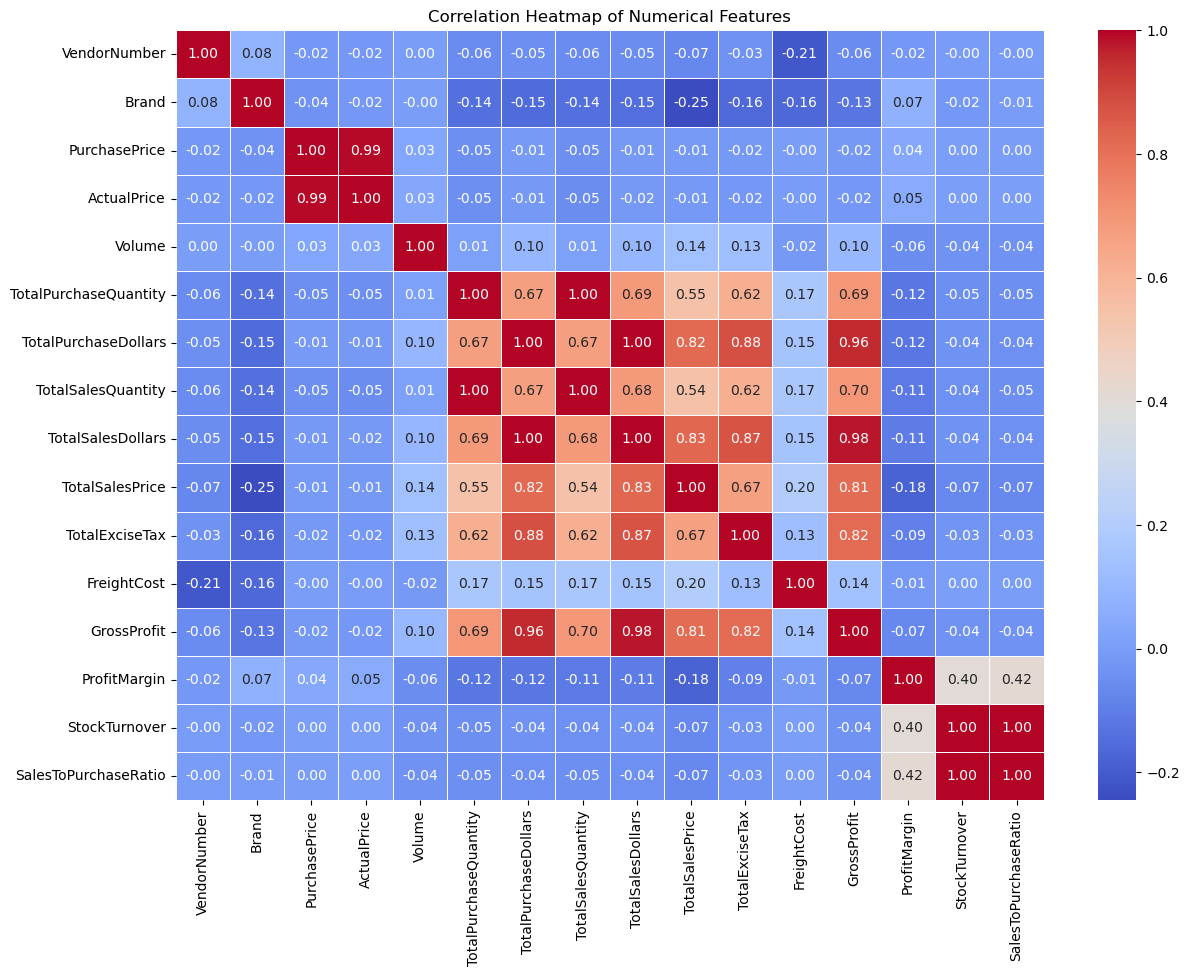

In [40]:
plt.figure(figsize=(14, 10))

numerical_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[numerical_cols].corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm",linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

# Correlation Insights

+ PurchasePrice has weak correlations with TotalSalesDollars (-0.012) and GrossProfit (-0.016), suggesting that price variations do not significantly impact sales revenue or profit.

+ Strong correlation between total purchase quantity and total sales quantity (0.999), confirming efficient inventory turnover.

+ Negative correlation between profit margin & total sales price (-0.179) suggests that as sales price increases, margins decrease, possibly due to competitive pricing pressures.

+ StockTurnover has weak negative correlations with both GrossProfit (-0.038) and ProfitMargin (-0.055), indicating that faster turnover does not necessarily result in higher profitability.

## DATA ANALYSIS

### Identify brands that needs promotional or pricing adjustment which exhibit lower sales performance but higher profit margins.

In [43]:
brand_performance=df.groupby('Description').agg({
    "TotalSalesDollars":'sum', 
    'ProfitMargin':'mean'
}).reset_index()

In [44]:
low_sales_threshold=brand_performance['TotalSalesDollars'].quantile(0.15)
high_margin_threshold=brand_performance['ProfitMargin'].quantile(0.85)

In [45]:
low_sales_threshold

np.float64(560.299)

In [46]:
high_margin_threshold

np.float64(64.97017552750113)

In [47]:
#brands with low sales but high profit margin 
target_brands=brand_performance[(brand_performance['TotalSalesDollars']<=low_sales_threshold) & 
    (brand_performance['ProfitMargin']>=high_margin_threshold)]
display(target_brands.sort_values('TotalSalesDollars'))

,Description,TotalSalesDollars,ProfitMargin
6199,Santa Rita Organic Svgn Bl,9.99,66.466466
2369,Debauchery Pnt Nr,11.58,65.975820
2070,Concannon Glen Ellen Wh Zin,15.95,83.448276
2188,Crown Royal Apple,27.86,89.806174
6237,Sauza Sprklg Wild Berry Marg,27.96,82.153076
...,...,...,...
5074,Nanbu Bijin Southern Beauty,535.68,76.747312
2271,Dad's Hat Rye Whiskey,538.89,81.851584
57,A Bichot Clos Marechaudes,539.94,67.740860
6245,Sbragia Home Ranch Merlot,549.75,66.444748


In [105]:
brand_performance=brand_performance[brand_performance['TotalSalesDollars']<10000]
brand_performance

,Description,TotalSalesDollars,ProfitMargin
6,12 Days of Pearls Gift Set,309.69,97.678323
8,13th Colony Sthrn Corn Whsky,359.82,42.446223
14,14 Hands Moscato,798.15,28.512184
18,14 Hands Rsl Wash,531.48,22.781666
35,2 Copas Spain White,119.88,33.333333
...,...,...,...
7692,Zoe Red by D Skouras,299.75,2.718932
7693,Zolo Malbec Rsv,713.63,21.169233
7694,Zonin Moscato,383.64,48.952143
7696,Zorah Red,417.81,67.559417


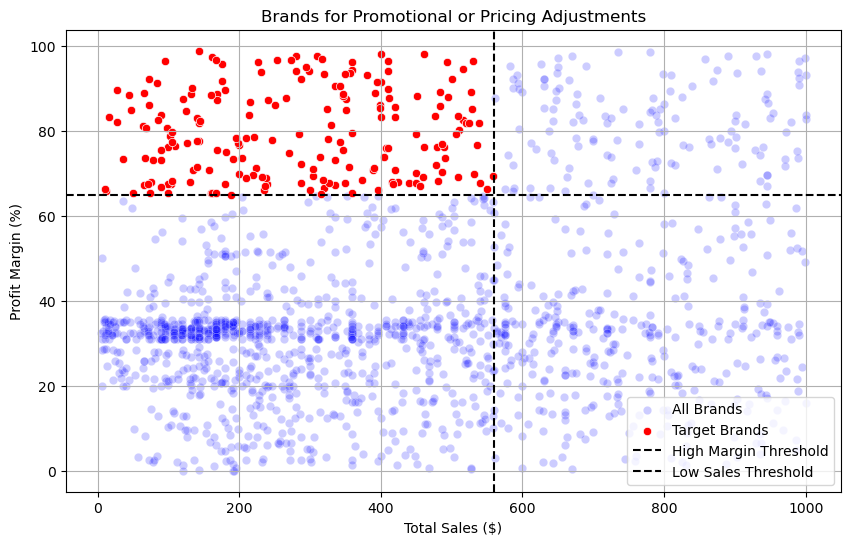

In [53]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=brand_performance, x='TotalSalesDollars', y='ProfitMargin', color="blue", label="All Brands", alpha=0.2)
sns.scatterplot(data=target_brands, x='TotalSalesDollars', y='ProfitMargin', color="red", label="Target Brands")

plt.axhline(high_margin_threshold, linestyle='--', color='black', label="High Margin Threshold")
plt.axvline(low_sales_threshold, linestyle='--', color='black', label="Low Sales Threshold")

plt.xlabel("Total Sales ($)")
plt.ylabel("Profit Margin (%)")
plt.title("Brands for Promotional or Pricing Adjustments")
plt.legend()
plt.grid(True)
plt.show()

### Which vendor & brands demonstrate highest sales performance?

In [106]:
top_vendors=df.groupby('VendorName')['TotalSalesDollars'].sum().nlargest(10)
top_brands=df.groupby('Description')['TotalSalesDollars'].sum().nlargest(10)
top_vendors

VendorName
DIAGEO NORTH AMERICA INC      6.799010e+07
MARTIGNETTI COMPANIES         3.933036e+07
PERNOD RICARD USA             3.206320e+07
JIM BEAM BRANDS COMPANY       3.142302e+07
BACARDI USA INC               2.485482e+07
CONSTELLATION BRANDS INC      2.421875e+07
E & J GALLO WINERY            1.839990e+07
BROWN-FORMAN CORP             1.824723e+07
ULTRA BEVERAGE COMPANY LLP    1.650254e+07
M S WALKER INC                1.470646e+07
Name: TotalSalesDollars, dtype: float64

In [107]:
top_brands

Description
Jack Daniels No 7 Black    7964746.76
Tito's Handmade Vodka      7399657.58
Grey Goose Vodka           7209608.06
Capt Morgan Spiced Rum     6356320.62
Absolut 80 Proof           6244752.03
Jameson Irish Whiskey      5715759.69
Ketel One Vodka            5070083.56
Baileys Irish Cream        4150122.07
Kahlua                     3604858.66
Tanqueray                  3456697.90
Name: TotalSalesDollars, dtype: float64

In [57]:
def format_dollars(value):
    if value >= 1_000_000:
        return f"{value/1_000_000:.2f}M"
    elif value >= 1_000:
        return f"{value/1_000:.2f}K"
    else:
        return str(value)


In [58]:
top_brands.apply(lambda x : format_dollars(x))

Description
Jack Daniels No 7 Black    7.96M
Tito's Handmade Vodka      7.40M
Grey Goose Vodka           7.21M
Capt Morgan Spiced Rum     6.36M
Absolut 80 Proof           6.24M
Jameson Irish Whiskey      5.72M
Ketel One Vodka            5.07M
Baileys Irish Cream        4.15M
Kahlua                     3.60M
Tanqueray                  3.46M
Name: TotalSalesDollars, dtype: object

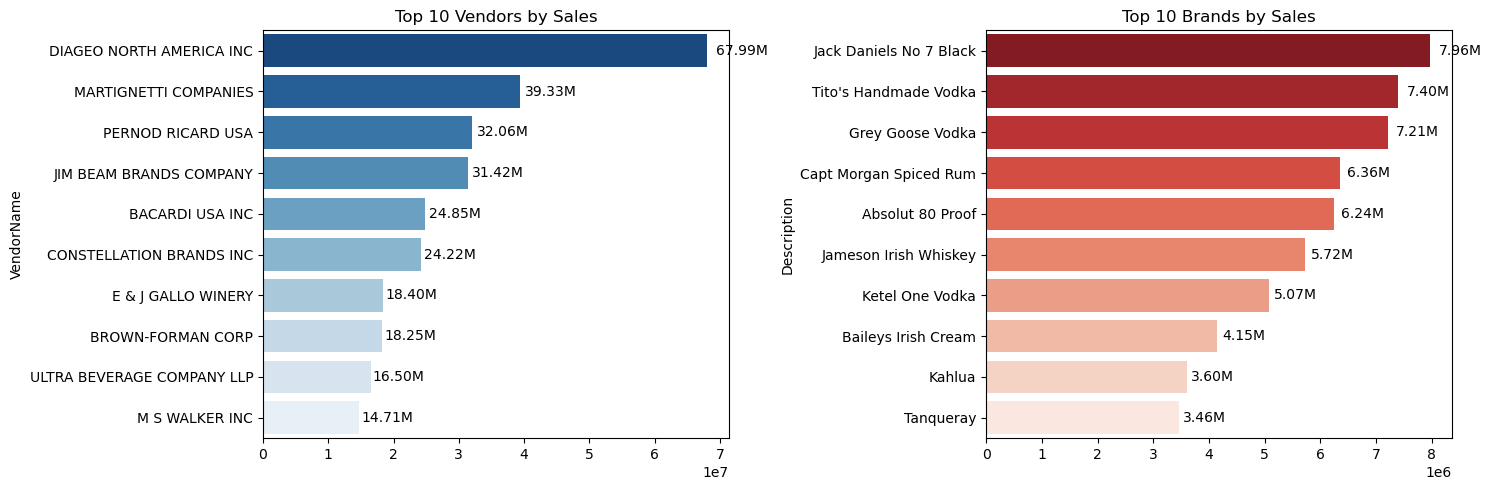

In [59]:
plt.figure(figsize=(15, 5))

# Plot for Top Vendors
plt.subplot(1, 2, 1)
ax1 = sns.barplot(y=top_vendors.index, x=top_vendors.values, palette="Blues_r")
plt.title("Top 10 Vendors by Sales")

for bar in ax1.patches:
    ax1.text(bar.get_width() + (bar.get_width() * 0.02),
    bar.get_y() + bar.get_height() / 2,
    format_dollars(bar.get_width()),
    ha='left', va='center', fontsize=10, color='black')

# Plot for Top Brands
plt.subplot(1, 2, 2)
ax2 = sns.barplot(y=top_brands.index.astype(str), x=top_brands.values, palette="Reds_r")
plt.title("Top 10 Brands by Sales")

for bar in ax2.patches:
    ax2.text(bar.get_width() + (bar.get_width() * 0.02),
    bar.get_y() + bar.get_height() / 2,
    format_dollars(bar.get_width()),
    ha='left', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

### Which vendor contribute the most to total purchase dollars?

In [110]:
vendor_performance=df.groupby('VendorName').agg({
    'TotalPurchaseDollars':'sum',
    'GrossProfit':'sum', 
    'TotalSalesDollars':'sum'
}).reset_index()

In [112]:
vendor_performance['PurchaseContribution(%)']=vendor_performance['TotalPurchaseDollars']/vendor_performance['TotalPurchaseDollars'].sum()*100
vendor_performance=round(vendor_performance.sort_values('PurchaseContribution(%)',ascending=False),2)
vendor_performance

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution(%)
25,DIAGEO NORTH AMERICA INC,50097226.16,17892873.26,67990099.42,16.30
57,MARTIGNETTI COMPANIES,25502095.83,13828263.53,39330359.36,8.30
68,PERNOD RICARD USA,23851164.17,8212032.02,32063196.19,7.76
46,JIM BEAM BRANDS COMPANY,23494304.32,7928716.14,31423020.46,7.64
6,BACARDI USA INC,17432020.26,7422796.88,24854817.14,5.67
...,...,...,...,...,...
33,FANTASY FINE WINES CORP,128.64,198.95,327.59,0.00
107,UNCORKED,118.74,58.20,176.94,0.00
85,SILVER MOUNTAIN CIDERS,77.18,265.33,342.51,0.00
16,CAPSTONE INTERNATIONAL,54.64,192.23,246.87,0.00


In [113]:
top_vendors=vendor_performance.head(10)
top_vendors['TotalSalesDollars']=top_vendors['TotalSalesDollars'].apply(format_dollars)
top_vendors['GrossProfit']=top_vendors['GrossProfit'].apply(format_dollars)
top_vendors['TotalPurchaseDollars']=top_vendors['TotalPurchaseDollars'].apply(format_dollars)

In [114]:
top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution(%)
25,DIAGEO NORTH AMERICA INC,50.10M,17.89M,67.99M,16.30
57,MARTIGNETTI COMPANIES,25.50M,13.83M,39.33M,8.30
68,PERNOD RICARD USA,23.85M,8.21M,32.06M,7.76
46,JIM BEAM BRANDS COMPANY,23.49M,7.93M,31.42M,7.64
6,BACARDI USA INC,17.43M,7.42M,24.85M,5.67
20,CONSTELLATION BRANDS INC,15.27M,8.95M,24.22M,4.97
11,BROWN-FORMAN CORP,13.24M,5.01M,18.25M,4.31
30,E & J GALLO WINERY,12.07M,6.33M,18.40M,3.93
106,ULTRA BEVERAGE COMPANY LLP,11.17M,5.34M,16.50M,3.63
53,M S WALKER INC,9.76M,4.94M,14.71M,3.18


In [115]:
top_vendors['CumulativeContribution%']=top_vendors['PurchaseContribution(%)'].cumsum()
top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution(%),CumulativeContribution%
25,DIAGEO NORTH AMERICA INC,50.10M,17.89M,67.99M,16.30,16.30
57,MARTIGNETTI COMPANIES,25.50M,13.83M,39.33M,8.30,24.60
68,PERNOD RICARD USA,23.85M,8.21M,32.06M,7.76,32.36
46,JIM BEAM BRANDS COMPANY,23.49M,7.93M,31.42M,7.64,40.00
6,BACARDI USA INC,17.43M,7.42M,24.85M,5.67,45.67
20,CONSTELLATION BRANDS INC,15.27M,8.95M,24.22M,4.97,50.64
11,BROWN-FORMAN CORP,13.24M,5.01M,18.25M,4.31,54.95
30,E & J GALLO WINERY,12.07M,6.33M,18.40M,3.93,58.88
106,ULTRA BEVERAGE COMPANY LLP,11.17M,5.34M,16.50M,3.63,62.51
53,M S WALKER INC,9.76M,4.94M,14.71M,3.18,65.69


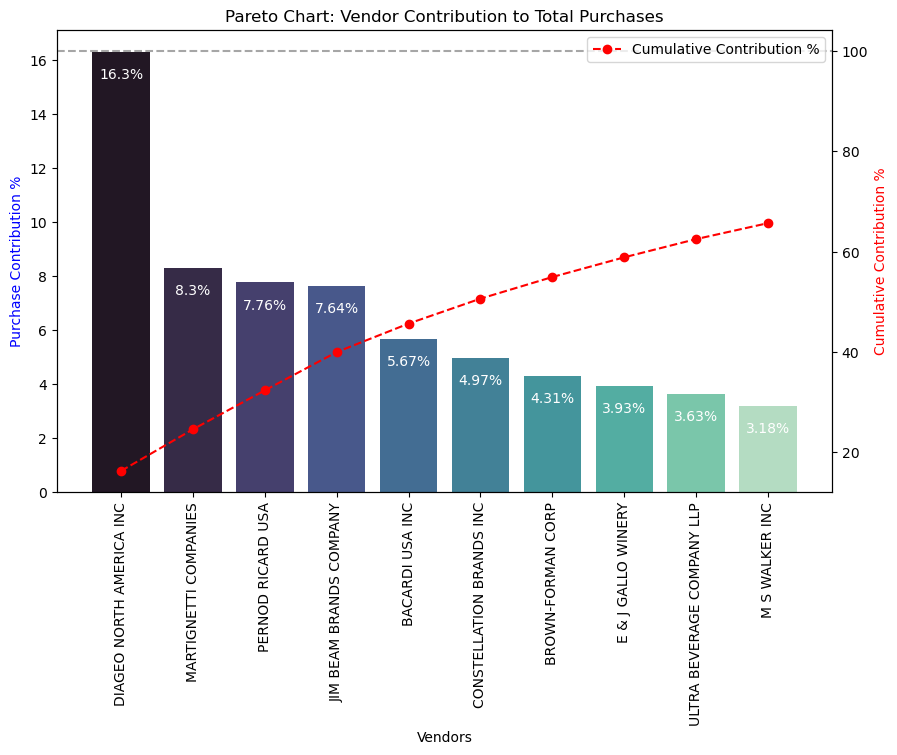

In [119]:
fig, ax1 = plt.subplots(figsize=(10,6))

sns.barplot(x=top_vendors['VendorName'], y=top_vendors['PurchaseContribution(%)'], palette="mako", ax=ax1)

# Add data labels on bars
for i, value in enumerate(top_vendors['PurchaseContribution(%)']):
    ax1.text(i, value - 1, str(value) + '%', ha='center', fontsize=10, color='white')

# Line Plot for Cumulative Contribution %
ax2 = ax1.twinx()
ax2.plot(top_vendors['VendorName'], top_vendors['CumulativeContribution%'], color='red', marker='o', linestyle='dashed', label='Cumulative Contribution %')

# Axis labels
ax1.set_xticklabels(top_vendors['VendorName'], rotation=90)
ax1.set_ylabel('Purchase Contribution %', color='blue')
ax2.set_ylabel('Cumulative Contribution %', color='red')
ax1.set_xlabel('Vendors')

# Title
ax1.set_title('Pareto Chart: Vendor Contribution to Total Purchases')

# Reference line at 100%
ax2.axhline(y=100, color='gray', linestyle='dashed', alpha=0.7)

# Legend
ax2.legend(loc='upper right')

plt.show()


### How much of total procurement is dependent on the top vendors?

In [120]:
print(f'Total Purchase Contribution of top 10 vendors is {round(top_vendors['PurchaseContribution(%)'].sum(),2)}%')

Total Purchase Contribution of top 10 vendors is 65.69%


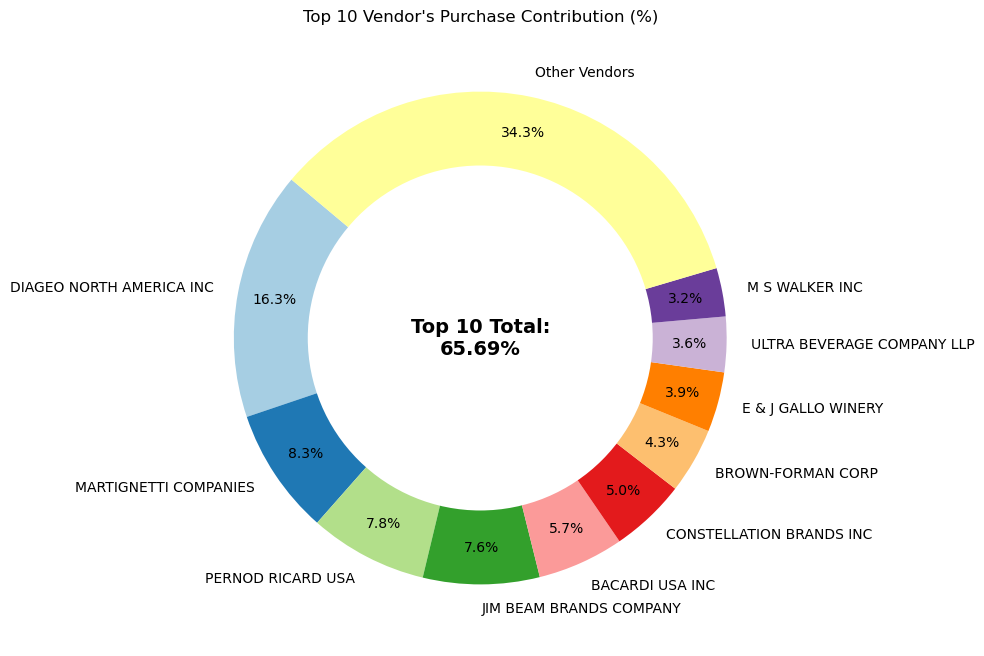

In [122]:
vendors = list(top_vendors['VendorName'].values)
purchase_contributions = list(top_vendors['PurchaseContribution(%)'].values)
total_contribution = sum(purchase_contributions)
remaining_contribution = 100 - total_contribution

# Append "Other Vendors" category
vendors.append("Other Vendors")
purchase_contributions.append(remaining_contribution)

# Donut Chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(purchase_contributions, labels=vendors, autopct='%1.1f%%',
    startangle=140, pctdistance=0.85, colors=plt.cm.Paired.colors)

# Draw a white circle in the center to create a "donut" effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Add Total Contribution annotation in the center
plt.text(0, 0, f"Top 10 Total:\n{total_contribution:.2f}%", fontsize=14, fontweight='bold', ha='center', va='center')

plt.title("Top 10 Vendor's Purchase Contribution (%)")
plt.show()

### Does purchasing in bulk reduce the unit price and what is the optimal purchase volume for cost saving

In [123]:
df['UnitPurchasePrice']=df['TotalPurchaseDollars']/df['TotalPurchaseQuantity']

In [126]:
df['OrderSize']=pd.qcut(df['TotalPurchaseQuantity'],q=3, labels=['Small','Medium','Large'])

In [129]:
df[['OrderSize','TotalPurchaseQuantity']]

,OrderSize,TotalPurchaseQuantity
0,Large,145080.0
1,Large,164038.0
2,Large,187407.0
3,Large,201682.0
4,Large,138109.0
...,...,...
8559,Small,2.0
8560,Small,6.0
8561,Small,2.0
8562,Small,1.0


In [131]:
df.groupby('OrderSize')[['UnitPurchasePrice']].mean()

,UnitPurchasePrice
OrderSize,
Small,39.068186
Medium,15.486414
Large,10.777625


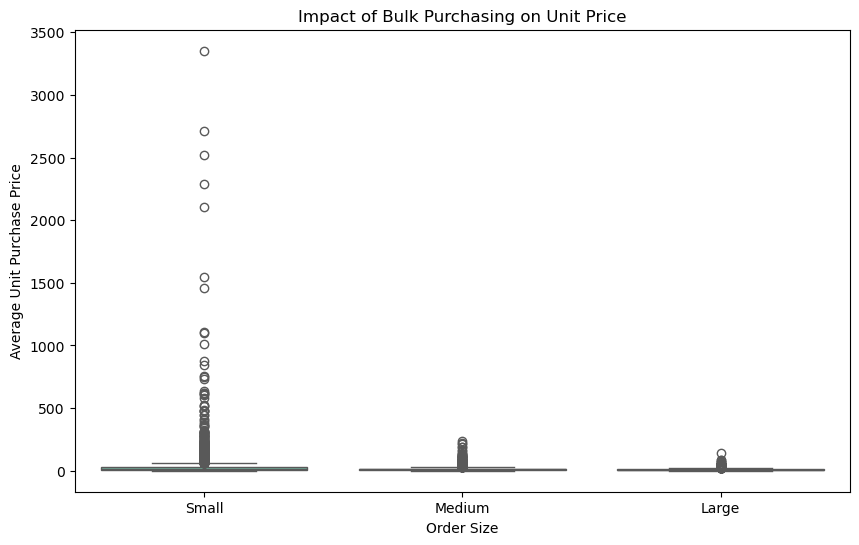

In [132]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="OrderSize", y="UnitPurchasePrice", palette="Set2")
plt.title("Impact of Bulk Purchasing on Unit Price")
plt.xlabel("Order Size")
plt.ylabel("Average Unit Purchase Price")
plt.show()

- Vendors buying in bulk (Large Order Size) get the lowest unit price ($10.78 per unit), meaning higher margins if they can manage inventory efficiently.

- The price difference between Small and Large orders is substantial (~72% reduction in unit cost)

- This suggests that bulk pricing strategies successfully encourage vendors to purchase in larger volumes, leading to higher overall sales despite lower per-unit revenue.

### Which vendor have low inventory turnover, indicating excess stock and slow-moving products?

In [139]:
df[df['StockTurnover']<1].groupby('VendorName')[['StockTurnover']].mean().sort_values('StockTurnover',ascending=True).head(10)

,StockTurnover
VendorName,
ALISA CARR BEVERAGES,0.615385
HIGHLAND WINE MERCHANTS LLC,0.708333
PARK STREET IMPORTS LLC,0.751306
Circa Wines,0.755676
Dunn Wine Brokers,0.766022
CENTEUR IMPORTS LLC,0.773953
SMOKY QUARTZ DISTILLERY LLC,0.783835
TAMWORTH DISTILLING,0.797078
THE IMPORTED GRAPE LLC,0.807569


### How much capital is locked in unsold inventory per vendor, and which vendors contribute the most to it?

In [143]:
df['UnsoldInventoryValue']=(df['TotalPurchaseQuantity']-df['TotalSalesQuantity'])*df['PurchasePrice']
print('Total Usold Capital:', format_dollars(df['UnsoldInventoryValue'].sum()))

Total Usold Capital: 2.71M


In [144]:
# Aggregate Capital Locked per Vendor
inventory_value_per_vendor = df.groupby("VendorName")["UnsoldInventoryValue"].sum().reset_index()

# Sort Vendors with the Highest Locked Capital
inventory_value_per_vendor = inventory_value_per_vendor.sort_values(by="UnsoldInventoryValue", ascending=False)

inventory_value_per_vendor['UnsoldInventoryValue'] = inventory_value_per_vendor['UnsoldInventoryValue'].apply(format_dollars)
inventory_value_per_vendor.head(10)

,VendorName,UnsoldInventoryValue
25,DIAGEO NORTH AMERICA INC,722.21K
46,JIM BEAM BRANDS COMPANY,554.67K
68,PERNOD RICARD USA,470.63K
116,WILLIAM GRANT & SONS INC,401.96K
30,E & J GALLO WINERY,228.28K
79,SAZERAC CO INC,198.44K
11,BROWN-FORMAN CORP,177.73K
20,CONSTELLATION BRANDS INC,133.62K
61,MOET HENNESSY USA INC,126.48K
77,REMY COINTREAU USA INC,118.60K


### What is the 95% confidence intervals for profit margins of top-performing and low-performing vendors

In [151]:
top_threshold=df["TotalSalesDollars"].quantile(0.75)
low_threshold=df["TotalSalesDollars"].quantile(0.25)

In [152]:
top_vendors=df[df['TotalSalesDollars']>=top_threshold]['ProfitMargin'].dropna()
low_vendors=df[df['TotalSalesDollars']<=low_threshold]['ProfitMargin'].dropna()

In [154]:
def confidence_interval(data, confidence=0.95):
    mean_val = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(len(data))  # Standard error
    t_critical = stats.t.ppf((1 + confidence) / 2, df=len(data) - 1)
    margin_of_error = t_critical * std_err
    return mean_val, mean_val - margin_of_error, mean_val + margin_of_error

Top Vendors 95% CI: (30.74, 31.61), Mean: 31.18
Low Vendors 95% CI: (40.50, 42.64), Mean: 41.57


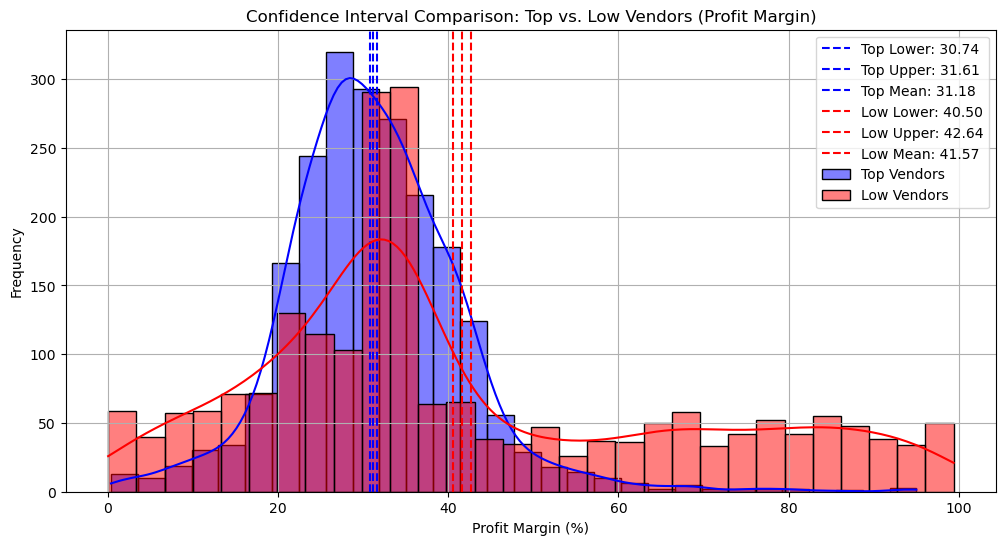

In [155]:
top_mean, top_lower, top_upper = confidence_interval(top_vendors)
low_mean, low_lower, low_upper = confidence_interval(low_vendors)

print(f"Top Vendors 95% CI: ({top_lower:.2f}, {top_upper:.2f}), Mean: {top_mean:.2f}")
print(f"Low Vendors 95% CI: ({low_lower:.2f}, {low_upper:.2f}), Mean: {low_mean:.2f}")

plt.figure(figsize=(12, 6))

# Top Vendors Plot
sns.histplot(top_vendors, kde=True, color="blue", bins=30, alpha=0.5, label="Top Vendors")
plt.axvline(top_lower, color="blue", linestyle="--", label=f"Top Lower: {top_lower:.2f}")
plt.axvline(top_upper, color="blue", linestyle="--", label=f"Top Upper: {top_upper:.2f}")
plt.axvline(top_mean, color="blue", linestyle="--", label=f"Top Mean: {top_mean:.2f}")

# Low Vendors Plot
sns.histplot(low_vendors, kde=True, color="red", bins=30, alpha=0.5, label="Low Vendors")
plt.axvline(low_lower, color="red", linestyle="--", label=f"Low Lower: {low_lower:.2f}")
plt.axvline(low_upper, color="red", linestyle="--", label=f"Low Upper: {low_upper:.2f}")
plt.axvline(low_mean, color="red", linestyle="--", label=f"Low Mean: {low_mean:.2f}")

# Finalize Plot
plt.title("Confidence Interval Comparison: Top vs. Low Vendors (Profit Margin)")
plt.xlabel("Profit Margin (%)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

- The confidence interval for low-performing vendors (40.50% to 42.64%) is significantly higher than that of top-performing vendors (30.74% to 31.61%).

- This suggests that vendors with lower sales tend to maintain higher profit margins, potentially due to premium pricing or lower operational costs.

- For High-Performing Vendors: If they aim to improve profitability, they could explore selective price adjustments, cost optimization, or bundling strategies.

- For Low-Performing Vendors: Despite higher margins, their low sales volume might indicate a need for better marketing, competitive pricing, or improved distribution strategies.

### Is there a significant difference in profit margins between top-performing and low-performing vendors?

Hypothesis:

H₀ (Null Hypothesis): There is no significant difference in the mean profit margins of top-performing and low-performing vendors.

H₁ (Alternative Hypothesis): The mean profit margins of top-performing and low-performing vendors are significantly different.

In [157]:
top_threshold = df["TotalSalesDollars"].quantile(0.75)
low_threshold = df["TotalSalesDollars"].quantile(0.25)

top_vendors = df[df["TotalSalesDollars"] >= top_threshold]["ProfitMargin"].dropna()
low_vendors = df[df["TotalSalesDollars"] <= low_threshold]["ProfitMargin"].dropna()

# Two-Sample T-Test
t_stat, p_value = ttest_ind(top_vendors, low_vendors, equal_var=False)

# Print results
print(f"T-Statistic: {t_stat:.4f}, P-Value: {p_value:.4f}")
if p_value < 0.05:
    print("Reject H₀: There is a significant difference in profit margins between top and low-performing vendors.")
else:
    print("Fail to Reject H₀: No significant difference in profit margins.")

T-Statistic: -17.6695, P-Value: 0.0000
Reject H₀: There is a significant difference in profit margins between top and low-performing vendors.
